# Plot total ARs

The second last step in AR calculations. Plots the total ARs counted in NDJFM and ND datasets

* Input: 
    - AR totals: `/glade/work/mkorendy/metisregimes/resolution/data.AR.10%.PNA.months.nc`

1. For ND, get the appropriate times and ensembles
    * Input: `/glade/work/mkorendy/metisregimes/tco1279/metis.z500_pna_ND_lpfilter_twicedaily_10days.1986-2016.anoms.nc`

2. Plot the total
    * Output: `/glade/work/mkorendy/metisregimes/resolution/data.AR.10%.PNA.months.k5.total.png`

## Constants

In [86]:
res = '1279'
era5 = False

threshold = '10%'
crit_val = 259.0

months = 'ND'

k = 5

## Imports

In [87]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np

## Files

In [88]:
# Path
if res == '199' or era5 == True:
    path = '/glade/work/mkorendy/metisregimes/'
else:
    path = '/glade/work/mkorendy/metisregimes/tco' + res + '/'
    
# Input and output
if era5 == False:
    
    if res != '1279':
        # Metis composite input
        f_tot = path + 'metis' + res + '.AR.' + threshold + '.PNA.NDJFM.nc'
    else:
        f_tot = path + 'metis' + res + '.AR.' + threshold + '.PNA.ND.nc'

    # Picture output
    f_pic = 'metis' + res + '.AR.' + threshold + '.PNA.' + months + '.k5.total.png'

else:
    
    # ERA5 composite input
    f_tot = path + 'era5.AR.' + threshold + '.PNA.NDJFM.nc'
    
    # Picture output
    f_pic = 'era5.AR.' + threshold + '.PNA.' + months + '.k5.total.png'

# Times input
if months == 'NDJFM' or res != 1279:
    f_times = '/glade/work/mkorendy/metisregimes/metis.z500_pna_NDJFM_lpfilter_twicedaily_10days.1986-2016.anoms.nc'
else:
    f_times = '/glade/work/mkorendy/metisregimes/tco1279/metis.z500_pna_ND_lpfilter_twicedaily_10days.1986-2016.anoms.nc'

In [89]:
print(f_tot)
print(f_pic)
print(f_times)

/glade/work/mkorendy/metisregimes/tco1279/metis1279.AR.10%.PNA.ND.nc
metis1279.AR.10%.PNA.ND.k5.total.png
/glade/work/mkorendy/metisregimes/metis.z500_pna_NDJFM_lpfilter_twicedaily_10days.1986-2016.anoms.nc


## Read data in

In [90]:
# Total rivers
ds = xr.open_dataset(f_tot)

# Appropriate time series
ds_times = xr.open_dataset(f_times)

print(ds)

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 41400)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 ... 41394 41395 41396 41397 41398 41399
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    river    (time, lat, lon) float64 ...


In [91]:
# Select appropriate time series and ensembles
if era5 == True:
    ds = ds.reindex(time=sorted(ds['time'].values))
    ds = ds.sel(time=ds_times.time)
elif months == 'ND' and res != '1279':
    ds = xr.DataArray(ds.river.values.reshape((len(ds_times.ensemble), len(ds_times.time),22,53)), 
                     coords={'ensemble':ds_times.ensemble.values, 'time':ds_times.time.values, 
                             'lat':ds['lat'].values, 'lon':ds['lon'].values},
                             dims=['ensemble','time', 'lat', 'lon']).to_dataset(name='river')
    ds_ND = xr.open_dataset('/glade/work/mkorendy/metisregimes/tco1279/metis.z500_pna_ND_lpfilter_twicedaily_10days.1986-2016.anoms.nc')
    ds = ds.sel(time=ds_ND.time, ensemble = ds_ND.ensemble)
    ds = xr.DataArray(ds.river.values.reshape((len(ds.ensemble)*len(ds.time),22,53)), 
                     coords={'time':np.arange(0,(len(ds.ensemble)*len(ds.time))), 
                             'lat':ds['lat'].values, 'lon':ds['lon'].values},
                             dims=['time', 'lat', 'lon']).to_dataset(name='river')

In [92]:
ds

<xarray.Dataset>
Dimensions:  (lat: 22, lon: 53, time: 41400)
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 ... 41394 41395 41396 41397 41398 41399
  * lat      (lat) float64 79.53 76.74 73.95 71.16 ... 29.3 26.51 23.72 20.93
  * lon      (lon) float64 151.9 154.7 157.5 160.3 ... 289.7 292.5 295.3 298.1
Data variables:
    river    (time, lat, lon) float64 ...

## Count the number of times a value exists

In [93]:
ds = ds.count('time')

In [94]:
# Scale metis data by ensemble number
if era5 == False and months == 'NDJFM':
    ds = ds/25
elif era5 == False:
    ds = ds/15
    print('15')

15


In [95]:
max(ds.river.values.flatten())

18.266666666666666

## Plot the totals

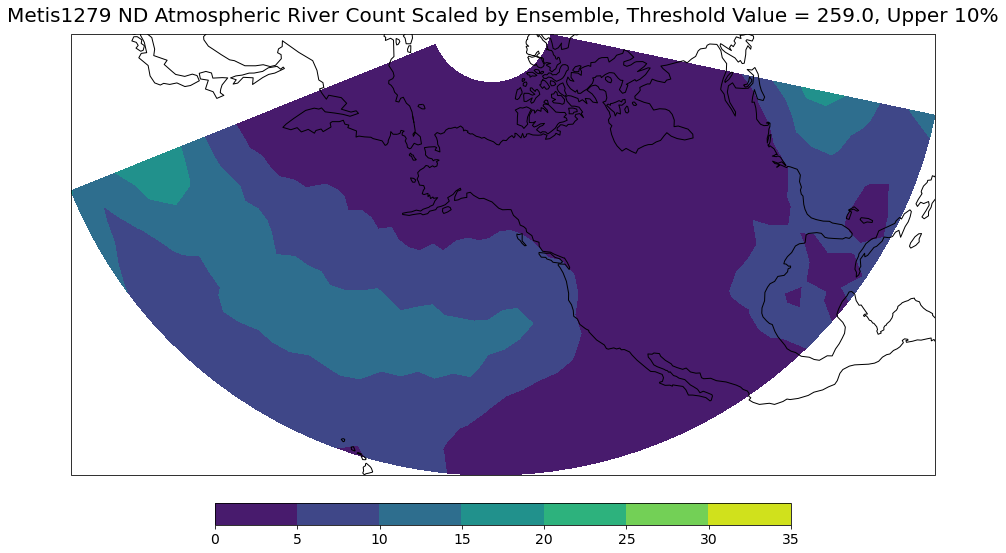

In [96]:
cm = 220

data_crs = ccrs.PlateCarree(central_longitude=cm)
proj = ccrs.NorthPolarStereo(central_longitude=cm)

# Set the contour levels
if months == 'NDJFM':
    clevs = np.arange(0,180,10)
else:
    clevs = np.arange(0,40,5)

# Set the axes using the specified map projection
fig,axs=plt.subplots(1,1,subplot_kw={'projection':proj},figsize=(20,15))

cs = axs.contourf(ds['lon'], ds['lat'], ds.river, clevs,transform=ccrs.PlateCarree())
axs.coastlines()
cbar_ax = fig.add_axes([0.3, 0.5, 0.4, 0.02])
cbar=fig.colorbar(cs, cax=cbar_ax,orientation='horizontal')
cbar.ax.tick_params(labelsize=14)
fig.subplots_adjust(bottom=0, top=1.5, left=0.2, right=0.8,
                    wspace=0.01, hspace=0.2)
if era5 == False:
    plt.suptitle('Metis' + res + ' ' + months + 
                 ' Atmospheric River Count Scaled by Ensemble, Threshold Value = ' + str(crit_val) + ', Upper '+ threshold,
                fontsize=20)
else:
    plt.suptitle('ERA5 ' + months + 
                 ' Atmospheric River Count, Threshold Value = ' + str(crit_val) + ', Upper '+ threshold,
                fontsize=20)
plt.savefig(f_pic)